# Setup Preparation

In [3]:
import gym
from gym import spaces
import numpy as np
from functools import reduce
import cv2

import matplotlib.pyplot as plt

In [4]:
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

# Env Creation

In [5]:
class Santa2k22(gym.Env):
    def __init__(self, resource_dir:str, do_render:bool = False):
        super(Santa2k22, self).__init__()
        
        self.state_space = cv2.imread(resource_dir+"/image.png")
        self.side, _, _ = self.state_space.shape
        self.observation_space = spaces.Box(low=-1, high=1, shape=(self.side, self.side),
                                     dtype=np.float32)
        
        self.key_to_links = dict({
            i : 2 ** (6-i) for i in range(8)
        })
        self.key_to_links[7] = 1
        self.action_space = spaces.Box(low=0, high=2, shape=(8,), dtype=int) # (links x direction) links; 0 => 64, 1 => 32 .... 7 => 1; direction; anticlock => 2, clock => 0, same position => 1
        
        self.state = None
        self.config = None
        self.done = False
        self.do_render = do_render
        # self.transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        # ])
        
    def reset(self):
        self.state = torch.zeros((self.side, self.side), dtype=torch.float32) - 1
        self.state[self.side//2+1, self.side//2+1] = 1
        
        self.config = [(64, 0), (-32, 0), (-16, 0), (-8, 0), (-4, 0), (-2, 0), (-1, 0), (-1, 0)]
        
        return self.state[None, ...]
    
    def _get_position(self, config:list):
        return reduce(lambda p, q: (p[0] + q[0], p[1] + q[1]), config, (0, 0))
    
    def _rotate_link(self, vector, direction):
        x, y = vector
        if direction == 2:  # counter-clockwise
            if y >= x and y > -x:
                x -= 1
            elif y > x and y <= -x:
                y -= 1
            elif y <= x and y < -x:
                x += 1
            else:
                y += 1
        elif direction == 0:  # clockwise
            if y > x and y >= -x:
                x += 1
            elif y >= x and y < -x:
                y += 1
            elif y < x and y <= -x:
                x -= 1
            else:
                y -= 1
        return (x, y)


    def _rotate(self, config, i, direction):
        config = config.copy()
        config[i] = self._rotate_link(config[i], direction)
        return config
    
    def _cartesian_to_array(self, x, y, shape):
        m, n = shape[:2]
        i = (n - 1) // 2 - y
        j = (n - 1) // 2 + x
        if i < 0 or i >= m or j < 0 or j >= n:
            raise ValueError("Coordinates not within given dimensions.")
        return i, j
    
    def _reconfiguration_cost(self, from_config, to_config):
        nlinks = len(from_config)
        diffs = np.abs(np.asarray(from_config) - np.asarray(to_config)).sum(axis=1)
        return np.sqrt(diffs.sum())

    def _color_cost(self, from_position, to_position, color_scale=3.0):
        return np.abs(self.state_space[to_position] - self.state_space[from_position]).sum() * color_scale

    def _step_cost(self, from_config, to_config):
        from_position = self._cartesian_to_array(*self._get_position(from_config), self.state_space.shape)
        to_position = self._cartesian_to_array(*self._get_position(to_config), self.state_space.shape)
        return (
            self._reconfiguration_cost(from_config, to_config) +
            self._color_cost(from_position, to_position)
        )

    def step(self, action):
        
        prev_config = self.config.copy()
        prev_pos = self._get_position(self.config)
        prev_pos_array = self._cartesian_to_array(*prev_pos, (self.side, self.side, 3))
        
        for idx, direction in enumerate(action):
            self.config = self._rotate(self.config, idx, direction)
        new_pos = self._get_position(self.config)
        new_pos_array = self._cartesian_to_array(*new_pos, (self.side, self.side, 3))
        
        if(self.state[new_pos_array] != 1):
            self.state[new_pos_array] = 1
        
        reward = -1 * self._step_cost(prev_config, self.config)
        
        if torch.all(self.state.eq(torch.ones((self.side, self.side), dtype=torch.float32))):
            self.done = True
        
        if self.render:
            self.render()
        
        return self.state[None, ...], reward, self.done, {}
    
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        
        if mode == "human":
            state = np.zeros((self.side, self.side), dtype = np.uint8)
            state[self.state.numpy() == -1] = 0
            state[self.state.numpy() == 1] = 255
            plt.title("Christmas Card")
            plt.imshow(state)
        elif mode == "rgb_array":
            return self.state
        
    def random_action_test(self, step:int=10):
        self.reset()
        for i in range(step):
            action = self.action_space.sample()
            next_state, reward, done, _ = self.step(action)
        
        self.render()

In [6]:
env = Santa2k22("../env/src/")

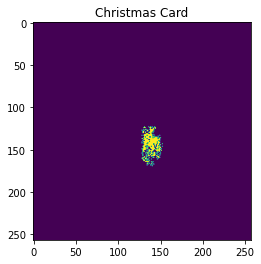

In [7]:
env.random_action_test(1000)

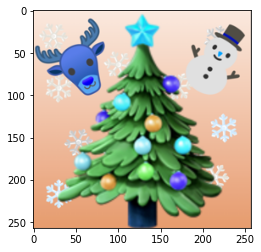

In [8]:
plt.imshow(env.state_space)

# DQN

DQN reference from https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

In [9]:
env = Santa2k22("../env/src/")
env.reset()

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [13]:
#https://stackoverflow.com/questions/72420221/how-to-get-a-2d-output-from-linear-layer-in-pytorch
class MultiDimLinear(torch.nn.Linear):
    def __init__(self, in_features, out_shape, **kwargs):
        self.out_shape = out_shape
        out_features = np.prod(self.out_shape)
        super().__init__(in_features, out_features, **kwargs)

    def forward(self, x):
        bs = x.shape[0]
        out = super().forward(x)
        return out.reshape(bs, *self.out_shape)


class DQN(nn.Module):

    def __init__(self, n_links):
        super(DQN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=8, stride=4) # 1 since input is grayscale
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.fc1 = nn.Linear(64*28*28, 512)
        self.out = MultiDimLinear(512, (n_links, 3))

    # Called with either one element to determine next action, or a batch
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = nn.Flatten()(x)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x

In [14]:
# op = DQN(env.action_space.shape[0])(torch.randn(128, 1, 257, 257))
# op.max(2)[1]

In [21]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the AdamW optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of links from gym action space
n_links = env.action_space.shape[0]

policy_net = DQN(n_links).to(device)
target_net = DQN(n_links).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state[None, ...].to(device)).max(2)[1][0]
    else:
        return torch.tensor(env.action_space.sample(), device=device, dtype=torch.long)

In [24]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))
    # for i in batch.action:
    #     print(i.shape)

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    # print(non_final_mask.shape)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    # print(non_final_next_states.shape)
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    # print("non_final_mask ", non_final_mask.shape)
    # print("non_final_next_states ", non_final_next_states.shape)
    # print("state_batch ", state_batch.shape)
    # print("action_batch ", action_batch.shape)
    # print("reward_batch ", reward_batch.shape)
    # print(state_batch.shape, action_batch.shape, reward_batch.shape)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch.to(device))
    # print("state_action_values ", state_action_values.shape)
    state_action_values = state_action_values.gather(2, action_batch.unsqueeze(-1)).squeeze(-1)
    # print("state_action_values ", state_action_values.shape)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros((BATCH_SIZE, n_links), device=device, dtype=torch.float)
    with torch.no_grad():
        # print(target_net(non_final_next_states).max(2)[1][0].shape)
        next_state_values[non_final_mask] = target_net(non_final_next_states.to(device)).max(2)[0]
        # print("next_state_values ", next_state_values.shape)
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.unsqueeze(-1)
    # print("expected_state_action_values ", expected_state_action_values.shape)
    # print(state_action_values.shape, expected_state_action_values.shape)
    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [ ]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    print("Episode ", i_episode)
    # Initialize the environment and get it's state
    state = env.reset()
    for t in count():
        action = select_action(state)
        observation, reward, done, _ = env.step(action)
        reward = torch.tensor([reward], device=device)

        if done:
            next_state = None
        else:
            next_state = observation
        # Store the transition in memory
        memory.push(state[None, ...], action[None, ...], next_state[None, ...], reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            break
    torch.save(policy_net, '/content/drive/MyDrive/src/santa_dqn'+i_episode+'.pth')

print('Complete')

Episode  0


In [ ]:
torch.save(policy_net, 'santa_dqn.pth')